In [1]:
from benchmark import *
from utils import *

from cellxgene_census.experimental.ml import ExperimentDataPipe, experiment_dataloader
import torch
from torch.utils.data import DataLoader
torch.ones(2).cuda();

### [Papermill](https://papermill.readthedocs.io/en/latest/) params:

In [2]:
# Set this to read from a local path
experiment_uri = None

# None ⟹ fetch from S3
census_uri = None
#census_uri = '/mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma'
census_version = "2023-12-15"

# By default:
# - `subset` if `experiment_uri` is a local path
# - `local` if `census_uri` is a local path
# - current (EC2 instance) region if `census_uri` is None (e.g. `us-east-1`, `us-west-2`)
name = None

collection_id = '283d65eb-dd53-496d-adb7-7570c7caa443'
# Slice datasets from `collection_id`
start = 2
end = 7

n_epochs = 1
batch_size = 1024
n_vars = 20_000
soma_chunk_size = 10_000
gc_freq: Optional[int] = None  # When set, run `gc.collect()` every `gc_freq` batches
exclude_first_batch = True

# Plot configs
ann_cutoff = .5  # Annotate plot with values for batch timings greater than this threshold
log_plot = False
width = 1200
height = 700

In [3]:
# Parameters
name = "subset-nvme"
experiment_uri = "/mnt/nvme/census-benchmark_2:7"
n_vars = 0


In [4]:
var_query = AxisQuery(coords=(slice(n_vars - 1),)) if n_vars else None

if experiment_uri:
    err(f"Loading experiment {experiment_uri}")
    with profile('open'):
        experiment = Experiment.open(experiment_uri)
    obs_query = None
    if name is None:
        if experiment_uri.startswith('/'):
            name = 'subset'
else:
    if not census_uri:
        census_uri = None
    
    if name is None:
        if census_uri and census_uri.startswith('/'):
            name = 'local'
        else:
            name = get_region()
    
    err(f"Loading census ({name})")

    with profile('open_soma'):
        census = cellxgene_census.open_soma(uri=census_uri, census_version=census_version)
    
    datasets = get_datasets(census, collection_id, 'datasets')
    err(f"{len(datasets)} datasets: {datasets[:10]}")
    
    experiment = census["census_data"]["homo_sapiens"]
    ds = datasets[slice(start, end)]
    datasets_query = "dataset_id in " + str(ds)
    obs_query = AxisQuery(value_filter=datasets_query)

if not name:
    raise ValueError("`name` not set")

experiment

Loading experiment /mnt/nvme/census-benchmark_2:7


<Experiment '/mnt/nvme/census-benchmark_2:7' (open for 'r') (2 items)
    'obs': 'file:///mnt/nvme/census-benchmark_2:7/obs' (unopened)
    'ms': 'file:///mnt/nvme/census-benchmark_2:7/ms' (unopened)>

In [5]:
%%time
with profile('get_exp_datapipe'):
    experiment_datapipe = ExperimentDataPipe(
        experiment,
        measurement_name="RNA",
        X_name="raw",
        obs_query=obs_query,
        var_query=var_query,
        batch_size=batch_size,
        shuffle=True,
        soma_chunk_size=soma_chunk_size,
    )
    loader = experiment_dataloader(experiment_datapipe)
exp = Exp(experiment_datapipe, loader)
exp

CPU times: user 4.11 ms, sys: 29 µs, total: 4.14 ms
Wall time: 3.91 ms


Exp(datapipe=ExperimentDataPipe, loader=<torch.utils.data.dataloader.DataLoader object at 0x7f876973ae50>)

In [6]:
%%time
exp.datapipe.shape[0]

CPU times: user 0 ns, sys: 185 ms, total: 185 ms
Wall time: 66.7 ms


133790

## Run benchmark

In [7]:
%%time
epochs = []
for epoch in range(n_epochs):
    with profile(f'benchmark-epoch{epoch}'):
        epoch = benchmark(exp, batch_size=batch_size, gc_freq=gc_freq, exclude_first_batch=exclude_first_batch)
    epochs.append(epoch)

results = Results(
    census=Method('census', epochs),
)

  0%|                                                                                            | 0/130 [00:00<?, ?it/s]

  1%|▋                                                                                   | 1/130 [00:00<00:29,  4.33it/s]

  2%|█▎                                                                                  | 2/130 [00:00<00:26,  4.86it/s]

  2%|█▉                                                                                  | 3/130 [00:00<00:25,  4.98it/s]

  3%|██▌                                                                                 | 4/130 [00:00<00:26,  4.69it/s]

  4%|███▏                                                                                | 5/130 [00:01<00:25,  4.85it/s]

  5%|███▉                                                                                | 6/130 [00:01<00:24,  5.01it/s]

  5%|████▌                                                                               | 7/130 [00:01<00:24,  5.05it/s]

  6%|█████▏                                                                              | 8/130 [00:01<00:23,  5.14it/s]

  7%|█████▊                                                                              | 9/130 [00:02<00:48,  2.48it/s]

  8%|██████▍                                                                            | 10/130 [00:02<00:43,  2.78it/s]

  8%|███████                                                                            | 11/130 [00:02<00:35,  3.36it/s]

  9%|███████▋                                                                           | 12/130 [00:03<00:29,  3.95it/s]

 10%|████████▎                                                                          | 13/130 [00:03<00:26,  4.47it/s]

 11%|████████▉                                                                          | 14/130 [00:03<00:23,  4.97it/s]

 12%|█████████▌                                                                         | 15/130 [00:03<00:21,  5.33it/s]

 12%|██████████▏                                                                        | 16/130 [00:03<00:20,  5.67it/s]

 13%|██████████▊                                                                        | 17/130 [00:03<00:19,  5.88it/s]

 14%|███████████▍                                                                       | 18/130 [00:06<01:47,  1.04it/s]

 15%|████████████▏                                                                      | 19/130 [00:06<01:20,  1.38it/s]

 15%|████████████▊                                                                      | 20/130 [00:06<01:01,  1.79it/s]

 16%|█████████████▍                                                                     | 21/130 [00:07<00:48,  2.26it/s]

 17%|██████████████                                                                     | 22/130 [00:07<00:38,  2.78it/s]

 18%|██████████████▋                                                                    | 23/130 [00:07<00:32,  3.29it/s]

 18%|███████████████▎                                                                   | 24/130 [00:07<00:27,  3.80it/s]

 19%|███████████████▉                                                                   | 25/130 [00:07<00:24,  4.25it/s]

 20%|████████████████▌                                                                  | 26/130 [00:07<00:22,  4.68it/s]

 21%|█████████████████▏                                                                 | 27/130 [00:08<00:36,  2.80it/s]

 22%|█████████████████▉                                                                 | 28/130 [00:08<00:30,  3.34it/s]

 22%|██████████████████▌                                                                | 29/130 [00:08<00:25,  3.92it/s]

 23%|███████████████████▏                                                               | 30/130 [00:09<00:22,  4.49it/s]

 24%|███████████████████▊                                                               | 31/130 [00:09<00:19,  4.95it/s]

 25%|████████████████████▍                                                              | 32/130 [00:09<00:18,  5.37it/s]

 25%|█████████████████████                                                              | 33/130 [00:09<00:17,  5.67it/s]

 26%|█████████████████████▋                                                             | 34/130 [00:09<00:16,  5.95it/s]

 27%|██████████████████████▎                                                            | 35/130 [00:09<00:15,  6.09it/s]

 28%|██████████████████████▉                                                            | 36/130 [00:10<00:15,  6.23it/s]

 28%|███████████████████████▌                                                           | 37/130 [00:10<00:35,  2.64it/s]

 29%|████████████████████████▎                                                          | 38/130 [00:11<00:31,  2.95it/s]

 30%|████████████████████████▉                                                          | 39/130 [00:11<00:25,  3.52it/s]

 31%|█████████████████████████▌                                                         | 40/130 [00:11<00:21,  4.10it/s]

 32%|██████████████████████████▏                                                        | 41/130 [00:11<00:19,  4.60it/s]

 32%|██████████████████████████▊                                                        | 42/130 [00:11<00:17,  5.07it/s]

 33%|███████████████████████████▍                                                       | 43/130 [00:11<00:16,  5.42it/s]

 34%|████████████████████████████                                                       | 44/130 [00:12<00:14,  5.74it/s]

 35%|████████████████████████████▋                                                      | 45/130 [00:12<00:14,  5.93it/s]

 35%|█████████████████████████████▎                                                     | 46/130 [00:15<01:23,  1.01it/s]

 36%|██████████████████████████████                                                     | 47/130 [00:15<01:03,  1.31it/s]

 37%|██████████████████████████████▋                                                    | 48/130 [00:15<00:48,  1.70it/s]

 38%|███████████████████████████████▎                                                   | 49/130 [00:15<00:37,  2.15it/s]

 38%|███████████████████████████████▉                                                   | 50/130 [00:15<00:30,  2.66it/s]

 39%|████████████████████████████████▌                                                  | 51/130 [00:16<00:24,  3.18it/s]

 40%|█████████████████████████████████▏                                                 | 52/130 [00:16<00:21,  3.69it/s]

 41%|█████████████████████████████████▊                                                 | 53/130 [00:16<00:18,  4.14it/s]

 42%|██████████████████████████████████▍                                                | 54/130 [00:16<00:16,  4.56it/s]

 42%|███████████████████████████████████                                                | 55/130 [00:18<00:48,  1.53it/s]

 43%|███████████████████████████████████▊                                               | 56/130 [00:18<00:39,  1.88it/s]

 44%|████████████████████████████████████▍                                              | 57/130 [00:18<00:30,  2.37it/s]

 45%|█████████████████████████████████████                                              | 58/130 [00:18<00:24,  2.91it/s]

 45%|█████████████████████████████████████▋                                             | 59/130 [00:18<00:20,  3.45it/s]

 46%|██████████████████████████████████████▎                                            | 60/130 [00:19<00:17,  3.99it/s]

 47%|██████████████████████████████████████▉                                            | 61/130 [00:19<00:15,  4.45it/s]

 48%|███████████████████████████████████████▌                                           | 62/130 [00:19<00:13,  4.89it/s]

 48%|████████████████████████████████████████▏                                          | 63/130 [00:19<00:12,  5.19it/s]

 49%|████████████████████████████████████████▊                                          | 64/130 [00:19<00:12,  5.49it/s]

 50%|█████████████████████████████████████████▌                                         | 65/130 [00:21<00:47,  1.36it/s]

 51%|██████████████████████████████████████████▏                                        | 66/130 [00:22<00:37,  1.71it/s]

 52%|██████████████████████████████████████████▊                                        | 67/130 [00:22<00:28,  2.17it/s]

 52%|███████████████████████████████████████████▍                                       | 68/130 [00:22<00:22,  2.70it/s]

 53%|████████████████████████████████████████████                                       | 69/130 [00:22<00:18,  3.23it/s]

 54%|████████████████████████████████████████████▋                                      | 70/130 [00:22<00:15,  3.76it/s]

 55%|█████████████████████████████████████████████▎                                     | 71/130 [00:22<00:13,  4.22it/s]

 55%|█████████████████████████████████████████████▉                                     | 72/130 [00:23<00:12,  4.65it/s]

 56%|██████████████████████████████████████████████▌                                    | 73/130 [00:23<00:11,  4.96it/s]

 57%|███████████████████████████████████████████████▏                                   | 74/130 [00:25<00:48,  1.14it/s]

 58%|███████████████████████████████████████████████▉                                   | 75/130 [00:25<00:37,  1.46it/s]

 58%|████████████████████████████████████████████████▌                                  | 76/130 [00:26<00:28,  1.89it/s]

 59%|█████████████████████████████████████████████████▏                                 | 77/130 [00:26<00:22,  2.38it/s]

 60%|█████████████████████████████████████████████████▊                                 | 78/130 [00:26<00:17,  2.91it/s]

 61%|██████████████████████████████████████████████████▍                                | 79/130 [00:26<00:14,  3.43it/s]

 62%|███████████████████████████████████████████████████                                | 80/130 [00:26<00:12,  3.95it/s]

 62%|███████████████████████████████████████████████████▋                               | 81/130 [00:26<00:11,  4.38it/s]

 63%|████████████████████████████████████████████████████▎                              | 82/130 [00:27<00:10,  4.79it/s]

 64%|████████████████████████████████████████████████████▉                              | 83/130 [00:28<00:33,  1.39it/s]

 65%|█████████████████████████████████████████████████████▋                             | 84/130 [00:29<00:26,  1.72it/s]

 65%|██████████████████████████████████████████████████████▎                            | 85/130 [00:29<00:20,  2.19it/s]

 66%|██████████████████████████████████████████████████████▉                            | 86/130 [00:29<00:16,  2.71it/s]

 67%|███████████████████████████████████████████████████████▌                           | 87/130 [00:29<00:13,  3.25it/s]

 68%|████████████████████████████████████████████████████████▏                          | 88/130 [00:29<00:11,  3.80it/s]

 68%|████████████████████████████████████████████████████████▊                          | 89/130 [00:30<00:09,  4.28it/s]

 69%|█████████████████████████████████████████████████████████▍                         | 90/130 [00:30<00:08,  4.74it/s]

 70%|██████████████████████████████████████████████████████████                         | 91/130 [00:30<00:07,  5.07it/s]

 71%|██████████████████████████████████████████████████████████▋                        | 92/130 [00:30<00:07,  5.37it/s]

 72%|███████████████████████████████████████████████████████████▍                       | 93/130 [00:33<00:38,  1.04s/it]

 72%|████████████████████████████████████████████████████████████                       | 94/130 [00:33<00:28,  1.28it/s]

 73%|████████████████████████████████████████████████████████████▋                      | 95/130 [00:33<00:20,  1.67it/s]

 74%|█████████████████████████████████████████████████████████████▎                     | 96/130 [00:34<00:15,  2.13it/s]

 75%|█████████████████████████████████████████████████████████████▉                     | 97/130 [00:34<00:12,  2.62it/s]

 75%|██████████████████████████████████████████████████████████████▌                    | 98/130 [00:34<00:10,  3.15it/s]

 76%|███████████████████████████████████████████████████████████████▏                   | 99/130 [00:34<00:08,  3.64it/s]

 77%|███████████████████████████████████████████████████████████████                   | 100/130 [00:34<00:07,  4.10it/s]

 78%|███████████████████████████████████████████████████████████████▋                  | 101/130 [00:34<00:06,  4.48it/s]

 78%|████████████████████████████████████████████████████████████████▎                 | 102/130 [00:36<00:17,  1.60it/s]

 79%|████████████████████████████████████████████████████████████████▉                 | 103/130 [00:36<00:13,  2.00it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 104/130 [00:36<00:10,  2.52it/s]

 81%|██████████████████████████████████████████████████████████████████▏               | 105/130 [00:37<00:08,  3.05it/s]

 82%|██████████████████████████████████████████████████████████████████▊               | 106/130 [00:37<00:06,  3.60it/s]

 82%|███████████████████████████████████████████████████████████████████▍              | 107/130 [00:37<00:05,  4.09it/s]

 83%|████████████████████████████████████████████████████████████████████              | 108/130 [00:37<00:04,  4.58it/s]

 84%|████████████████████████████████████████████████████████████████████▊             | 109/130 [00:37<00:04,  4.94it/s]

 85%|█████████████████████████████████████████████████████████████████████▍            | 110/130 [00:37<00:03,  5.29it/s]

 85%|██████████████████████████████████████████████████████████████████████            | 111/130 [00:38<00:08,  2.20it/s]

 86%|██████████████████████████████████████████████████████████████████████▋           | 112/130 [00:39<00:06,  2.61it/s]

 87%|███████████████████████████████████████████████████████████████████████▎          | 113/130 [00:39<00:05,  3.16it/s]

 88%|███████████████████████████████████████████████████████████████████████▉          | 114/130 [00:39<00:04,  3.73it/s]

 88%|████████████████████████████████████████████████████████████████████████▌         | 115/130 [00:39<00:03,  4.26it/s]

 89%|█████████████████████████████████████████████████████████████████████████▏        | 116/130 [00:39<00:02,  4.75it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 117/130 [00:39<00:02,  5.13it/s]

 91%|██████████████████████████████████████████████████████████████████████████▍       | 118/130 [00:40<00:02,  5.46it/s]

 92%|███████████████████████████████████████████████████████████████████████████       | 119/130 [00:40<00:01,  5.69it/s]

 92%|███████████████████████████████████████████████████████████████████████████▋      | 120/130 [00:40<00:01,  5.91it/s]

 93%|████████████████████████████████████████████████████████████████████████████▎     | 121/130 [00:42<00:06,  1.44it/s]

 94%|████████████████████████████████████████████████████████████████████████████▉     | 122/130 [00:42<00:04,  1.92it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▌    | 123/130 [00:42<00:02,  2.50it/s]

 95%|██████████████████████████████████████████████████████████████████████████████▏   | 124/130 [00:42<00:01,  3.21it/s]

 96%|██████████████████████████████████████████████████████████████████████████████▊   | 125/130 [00:42<00:01,  3.97it/s]

 97%|███████████████████████████████████████████████████████████████████████████████▍  | 126/130 [00:42<00:00,  4.80it/s]

 98%|████████████████████████████████████████████████████████████████████████████████  | 127/130 [00:43<00:00,  5.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████▋ | 128/130 [00:43<00:00,  6.33it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████▎| 129/130 [00:43<00:00,  6.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 130/130 [00:43<00:00,  5.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 130/130 [00:43<00:00,  2.97it/s]

time per sample: 328.68 μs
samples per sec: 3042.48 samples/sec
CPU times: user 1min 13s, sys: 37 s, total: 1min 50s
Wall time: 48.3 s


In [8]:
tdb.stats

{'open': [{'timers': {'Context.StorageManager.sm_load_group_metadata.sum': 6.8941e-05,
    'Context.StorageManager.sm_load_group_metadata.avg': 6.8941e-05,
    'Context.StorageManager.sm_load_group_from_uri.sum': 9.2418e-05,
    'Context.StorageManager.sm_load_group_from_uri.avg': 9.2418e-05,
    'Context.StorageManager.sm_load_group_details.sum': 9.7363e-05,
    'Context.StorageManager.sm_load_group_details.avg': 9.7363e-05,
    'Context.StorageManager.group_open_for_reads.sum': 9.9916e-05,
    'Context.StorageManager.group_open_for_reads.avg': 9.9916e-05},
   'counters': {'Context.StorageManager.read_unfiltered_byte_num': 262,
    'Context.StorageManager.read_group_size': 70,
    'Context.StorageManager.read_array_meta_size': 192,
    'Context.StorageManager.VFS.read_ops_num': 6,
    'Context.StorageManager.VFS.read_byte_num': 333,
    'Context.StorageManager.VFS.ls_num': 3}}],
 'get_exp_datapipe': [],
 'benchmark-epoch0': []}

In [9]:
tdbs.stats

{'open': [], 'get_exp_datapipe': [], 'benchmark-epoch0': []}

In [10]:
results_json_path = f'results/{name}.json'
with open(results_json_path, 'w') as f:
    json.dump(asdict(results), f, indent=2)
    err(f"Saved results to {results_json_path}")

Saved results to results/subset-nvme.json


In [11]:
# with open(results_json_path, 'r') as f:
#     results = Results(**json.load(f))

## Plot batch timings

In [12]:
method = 'census'
epoch = 0
batches = getattr(results, 'census').epochs[epoch].batches
df = pd.DataFrame(batches)
df['gc'] = df['gc'].fillna(nan)
if df.gc.isna().all():
    df = df.drop(columns='gc')
df.index.name = 'idx'
df = df.reset_index()
df

/tmp/ipykernel_2173/2254310219.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gc'] = df['gc'].fillna(nan)


,idx,batch
0,0,0.232285
1,1,0.188394
2,2,0.194566
3,3,0.232805
4,4,0.192950
...,...,...
125,125,0.105959
126,126,0.114891
127,127,0.106344
128,128,0.113499


In [13]:
ann = df[df.batch > ann_cutoff] if ann_cutoff else df[[]]
ann

,idx,batch
8,8,0.861731
17,17,2.799170
26,26,0.690087
36,36,0.885565
45,45,2.906172
54,54,1.665908
64,64,2.028988
73,73,2.442174
82,82,1.916068
92,92,3.018129


In [14]:
pc

PlotConfigs(fmt='fig', w=1200, h=800, save=[], v=True, i=None, dir=None, grid='#ccc', bg='white')

Saving: img/census-subset-nvme.png


Returning IPython Image


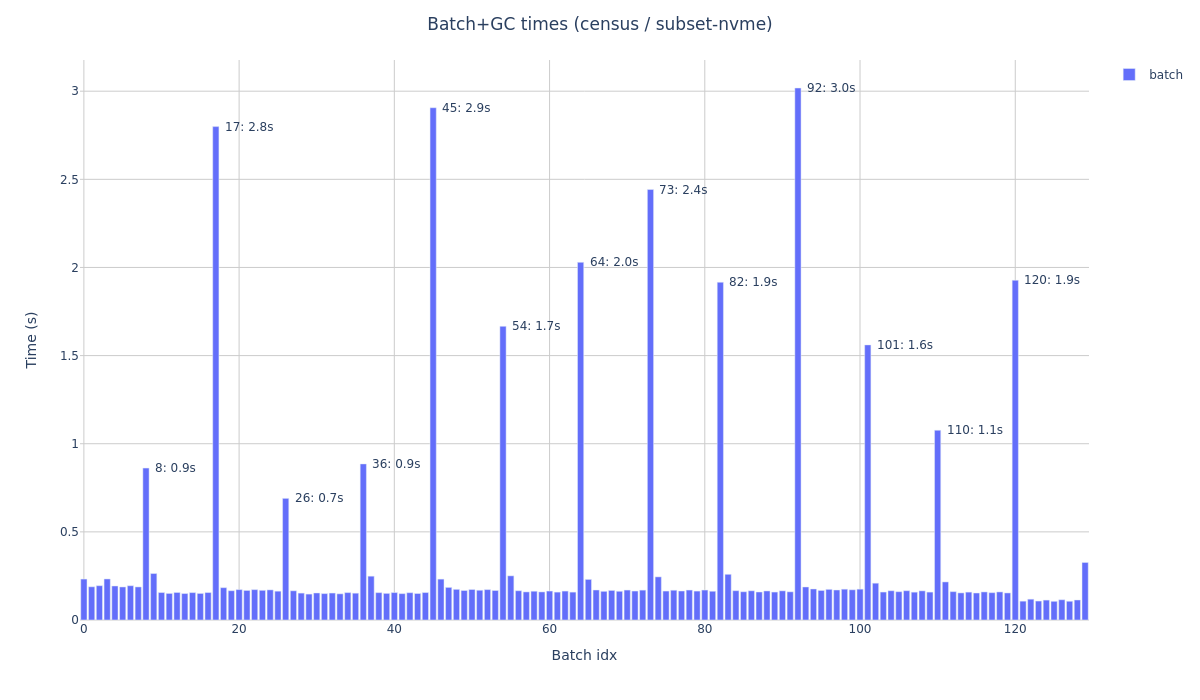

In [15]:
fig = px.bar(
    df.set_index('idx')[['batch', *(['gc'] if 'gc' in df else [])]],
    barmode='stack',
    labels={
        'idx': 'Batch idx',
        'variable': '',
        'value': 'Time (s)',
    },
    log_y=log_plot,
).update_layout(
    title=dict(text=f'Batch+GC times ({method} / {name})'),
).update_xaxes(
    range=(-.5, len(df) - 1 + .5),
)

if not ann.empty:
    anns = ann.set_index('idx').batch.to_dict().items()
    for idx, batch in anns:
        fig.add_annotation(
            x=idx, y=log10(batch) if log_plot else batch,
            showarrow=False,
            text=f'{idx}: {batch:.1f}s',
            xshift=7,
            xanchor='left',
        )

plot(fig, f'census-{name}', fmt='png', save=['png'], w=width, h=height, dir='img',)